In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import joblib
from tqdm import tqdm 
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import *

from utils import test_model_with_custom_inputs, create_bounds_dataframe
plt.style.use('science')

No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
expert_agent = pd.read_csv("data/data_generation_mpc_110_190_6_all.csv")

In [3]:
# Load X_scaler
X_scaler = joblib.load('data/scalers/X_scaler.pkl')

# Load y_scaler
y_scaler = joblib.load('data/scalers/y_scaler.pkl')


In [4]:
class LitNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2)
        self.train_loss = []
        self.val_loss = []

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Load the model state dictionary
model_state_dict = torch.load('data/model/trained_model.pth')

# Create an instance of the model
model = LitNeuralNet()

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)


<All keys matched successfully>

In [6]:
pumps_speeds = test_model_with_custom_inputs(100, 1.6, X_scaler, y_scaler, model)[1]
print(pumps_speeds)

[[953.68628747 771.97295517]]


In [7]:
custom_inputs_scaled = X_scaler.transform(expert_agent[["inflow", "height"]])
X = torch.tensor(custom_inputs_scaled, dtype=torch.float32)

In [8]:

n_sim = 100
height_sim = np.linspace(1.1, 1.6, n_sim)
inflow_sim = np.linspace(500, 700, n_sim)

# Time array
t = np.linspace(0, 1, n_sim)
height_sim = height_sim * (1.2 + 0.1 * np.sin(2 * np.pi *  t))

In [9]:
results_df_concat = []



for index in tqdm(range(0,n_sim)):
    height = height_sim[index]
    inflow = inflow_sim[index]
    X0, yhat = test_model_with_custom_inputs(inflow, height, X_scaler, y_scaler, model)
    epsilon = 0.1
    # Create perturbation
    perturbation = PerturbationLpNorm(norm=np.inf, eps=epsilon)
    # Convert the model to a Bounded Module
    bounded_model = BoundedModule(model, torch.empty_like(X), bound_opts={"forward_mode": "interval"})
    #Create a BoundedTensor from the input and perturbation
    bounded_input = BoundedTensor(X0, perturbation)
    #Compute bounds using the compute_bounds() method.


    with torch.no_grad():  # If gradients of the bounds are not needed, we can use no_grad to save memory.
        lb, ub = bounded_model.compute_bounds(x=(bounded_input,), method='CROWN')

            
    # Auxillary function to print bounds.
    results_df_concat.append(create_bounds_dataframe(lb, ub, yhat, inflow, height, y_scaler))


100%|██████████| 100/100 [00:04<00:00, 21.01it/s]


In [10]:
results_df = pd.concat(results_df_concat).reset_index(drop=True)

In [11]:
df_p1 = results_df[results_df["pump label"] == "pump1"]
df_p2 = results_df[results_df["pump label"] == "pump2"]

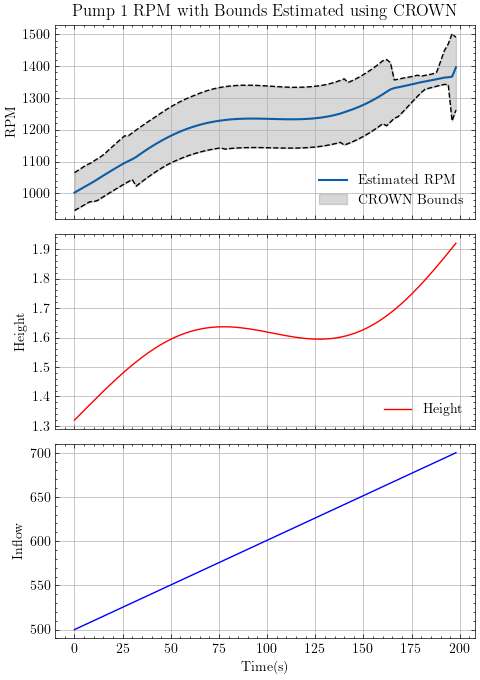

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7), sharex=True)

# Plot Pump 1 RPM with Bounds
ax1.plot(df_p1["pump_rpm estimated"], label="Estimated RPM", linewidth=1.5)
ax1.plot(df_p1["lower_bound"], color="black", linestyle='dashed')
ax1.plot(df_p1["upper_bound"], color="black", linestyle='dashed')
ax1.fill_between(df_p1.index, df_p1["lower_bound"], df_p1["upper_bound"], color="grey",alpha=0.3, label="CROWN Bounds")
ax1.set_xlabel("")
ax1.set_ylabel("RPM")
ax1.set_title("Pump 1 RPM with Bounds Estimated using CROWN")
ax1.legend(loc="lower right")
ax1.grid()

# Plot Height
ax2.plot(df_p1["height"], color="red", label="Height")
ax2.set_xlabel("")
ax2.set_ylabel("Height")
ax2.legend(loc="lower right")
ax2.grid()

# Plot Inflow
# Create a twin Axes sharing the x-axis with ax2
ax3.plot(df_p1["inflow"], color="blue", label="Inflow")
ax3.set_ylabel("Inflow")
ax3.set_xlabel("Time(s)")
ax2.legend(loc="lower right")
ax3.grid()

plt.tight_layout()  # Adjust the spacing between subplots

# Save the plot in PDF format with high quality
plt.savefig("plot.pdf", dpi=300)
plt.show()
